In [100]:
from IPython.core.display import HTML
import numpy as np
import math

[x3d](https://pypi.org/project/x3d) is a [PyPI](https://pypi.org) distributed Python package maintained by the 
[Web3D Consortium](https://web3d.org). See also a local help file [x3d.x3d](x3d.x3d.html) explaining the import statement 

`from x3d import x3d` .

In [101]:
from x3d import x3d

[common_geometry](common_geometry.html) is a Python package, local to this Jupyter notebook folder, which defines convenience classes for generating X3D elements with the geometric definitition pertinent to this notebook. See [common_geometry.py](common_geometry.py) for Python source code; [common_geometry](common_geometry.html) for documentation autogenerated by the [pydoc](https://docs.python.org/3/library/pydoc.html) documentation system.


In [102]:
import common_geometry

In [103]:
alpha_degrees = 30.0 # the half angle of the cone
beta_degrees  = 15.0 # the angle the intersecting plane makes with horizontal
a = 1.0              # distance of intersecting plane to cone vertex
f = 2.5              # total height of cone

if (alpha_degrees + beta_degrees >= 90.0):
    raise AssertionError("choice of alpha , beta angles geometrically invalid")




In [104]:
# convert angles to radians
alpha = math.radians(alpha_degrees)
beta  = math.radians(beta_degrees)


### Evaluation of geometry of the upper inscribed sphere
    
&#x2221;CBA = alpha

&#x2221;ACB = pi/2 - beta

&#x2223;AD is bisector of &#x2221;BAC

DE &#x22A5; AC







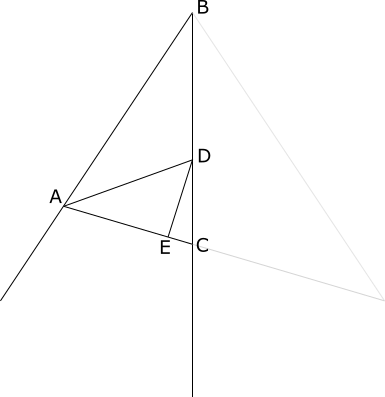

In [114]:
angCBA=alpha                       # alpha is half angle of cone

angBAC= math.pi/2 + beta - alpha   # angles in triangle sum to pi
angDAC= angBAC/2                   # AD segment is angle bisector of angle BAC
angACD= math.pi/2 - beta           # beta is angle that segment AC makes with horizontal
angCDA= math.pi - angDAC - angACD  # angles in triangle sum to pi

# now apply law of sines
disBC = a                          # definition of cone dimension a
disAC = math.sin(angCBA) * disBC / math.sin(angBAC) # law of sines
disCD = math.sin(angDAC) * disAC / math.sin(angCDA) # law of sines

disDE = disCD * math.sin(angACD)
disCE = disCD * math.cos(angACD)

upperCenterOffset = disCD
print("upperCenterOffset: %.5f" % upperCenterOffset)
upperRadius = disDE
print("upperRadius: %.5f" % upperRadius)

focus_u = disCE
major_u = disAC


upperCenterOffset: 0.34108
upperRadius: 0.32946


In [115]:


def TiltedPlane(a,b,beta):
    corners = np.array([
        ( a/2, 0, b/2),
        (-a/2, 0, b/2),
        (-a/2, 0,-b/2),
        ( a/2, 0,-b/2)
    ])
    
    M = np.array([
        ( math.cos(beta), -math.sin(beta) , 0),
        ( math.sin(beta),  math.cos(beta) , 0),
        ( 0             ,  0              , 1)
    ])
    
    coordinates = np.inner(corners, M)
    coordinates = [ tuple(pt) for pt in coordinates ]
    
    retVal = x3d.IndexedFaceSet()
    retVal.coord = x3d.Coordinate( point= list(coordinates))
    retVal.coordIndex = [0,1,2,3,-1]
    retVal.solid = False
    return retVal


    

### Lower, large sphere geometry

In [116]:
disBC = a
angCBA=alpha
angACB= math.pi/2 + beta
angBAC= math.pi - angCBA - angACB

angCAD = (math.pi-angBAC)/2
angDCA = math.pi/2 - beta
angADC = math.pi - angCAD - angDCA

disAC = math.sin(angCBA) * disBC/math.sin(angBAC)
disCD = math.sin(angCAD) * disAC/math.sin(angADC)
disAD = math.sin(angDCA) * disAC/math.sin(angADC)
disDE = disAD * math.sin(angCAD)
disCE = disCD * math.cos(angDCA)

lowerCenterOffset = disCD
print("lowerCenterOffset: %.5f" % lowerCenterOffset)
lowerRadius = disDE
print("lowerRadius: %.5f" % lowerRadius)

focus_l = disCE
print(focus_l)
major_l = disAC

lowerCenterOffset: 1.07313
lowerRadius: 1.03657
0.27774704738297223


In [117]:
semimajor = 0.5 * (major_u + major_l)
semifocus = 0.5 * (focus_u + focus_l)
semiminor = math.sqrt( math.pow(semimajor, 2) - math.pow( semifocus,2))
ellipse_center_offset = 0.5*(focus_u-focus_l)
ellipse_center_coordinate = np.array( (-math.cos(beta), math.sin(beta), 0.0)) * ellipse_center_offset

print("semiminor axis: %.5f" % semiminor)
print("semimajor axis: %.5f" % semimajor)

semiminor axis: 0.58439
semimajor axis: 0.61237


In [145]:

sc = x3d.Scene()
sc.children.append( x3d.Background(skyColor = [(1,1,1)]) )

cone_shape = x3d.Transform(
    translation = (0.0, a - a*f/2, 0),
    children = [x3d.Shape(
    geometry = x3d.Cone( bottomRadius= a*f*math.tan(alpha)  , height= a*f  ),
    appearance = x3d.Appearance(
        material = x3d.Material( diffuseColor=(0.0,0.5,0.5),transparency=0.75)
    ))]
)


plane_shape = common_geometry.TiltedPlane(
    length = 4.5,
    width  = 2.5, 
    beta   = beta, 
    appearance= x3d.Appearance( material = x3d.Material( emissiveColor=(1,0,0), transparency=0.0)) )

upper_sphere = common_geometry.Sphere( 
        center = (0.0, upperCenterOffset, 0.0),
        radius = upperRadius,
        appearance = x3d.Appearance( material = x3d.Material( diffuseColor=(1,1,0)) )
)

lower_sphere = common_geometry.Sphere( 
        center = (0.0, -lowerCenterOffset, 0.0),
        radius = lowerRadius,
        appearance = x3d.Appearance( material = x3d.Material( diffuseColor=(1,1,0.5)) )
)


figure = x3d.Transform(
    rotation=(0, -1, 0 ,math.radians(20.0)),
    children = [
        cone_shape,
        plane_shape,
        upper_sphere,
        lower_sphere       
    ]
)
sc.children.append(figure)


Explicitly construct the ellipse which is the intersection between the plane and the cone.

Will start with a circle, then stretch it by different scales in x and z axis to be the appropriate
ellipse, then rotate it around the z axis

In [146]:
ellipse_line_properties = x3d.LineProperties(linetype=1, linewidthScaleFactor=2)
ellipse_material = x3d.Material(emissiveColor=(0,1,0))

appearance = x3d.Appearance( lineProperties = ellipse_line_properties, material=ellipse_material )

circular_shape = x3d.Transform(
    rotation = (1.0, 0.0, 0.0, math.pi/2),
    children=[
        x3d.Shape(
            geometry = x3d.Circle2D(radius=1.0),
            appearance = appearance
        )
    ]
)

ellipse_shape = x3d.Transform(
    translation = tuple(ellipse_center_coordinate),
    children=[x3d.Transform(
        rotation=(0 , 0, -1, beta),
        children=[
            x3d.Transform(
                scale = (semimajor,1,semiminor),
                children = [circular_shape]
            )
        ]
    )             ]
)
figure.children.append(ellipse_shape)

In [147]:
%%html
<script type='text/javascript' charset="UTF-8" src='https://x3dom.org/release/x3dom-full.debug.js'> </script> 
<link rel='stylesheet' type='text/css' href='https://x3dom.org/release/x3dom.css'></link> 
<style>

 x3d {
     width:720px;
     height:720px;
     border:2px solid black;
}
</style>

In [141]:
x3dnode = """\
<x3d>
%s
</x3d>
<script>
window.x3dom.reload()
</script>
""" % sc.HTML5()

#print(x3dnode)
HTML(x3dnode)

In [144]:
if (True):
    print(sc.XML())

<Scene>
  <Background skyColor='1 1 1'/>
  <Transform rotation='0 -1 0 0.3490658503988659'>
    <Transform translation='0.0 -0.25 0'>
      <Shape>
        <Appearance>
          <Material diffuseColor='0.0 0.5 0.5' transparency='0.75'/>
        </Appearance>
        <Cone bottomRadius='1.443375672974064' height='2.5'/>
      </Shape>
    </Transform>
    <Transform>
      <Shape>
        <Appearance>
          <Material emissiveColor='1 0 0'/>
        </Appearance>
        <IndexedFaceSet coordIndex='0 1 2 3 -1' solid='false'>
          <Coordinate point='2.173333109150404 -0.5823428514806717 1.25 -2.173333109150404 0.5823428514806717 1.25 -2.173333109150404 0.5823428514806717 -1.25 2.173333109150404 -0.5823428514806717 -1.25'/>
        </IndexedFaceSet>
      </Shape>
    </Transform>
    <Transform translation='0.0 0.3410813774021088 0.0'>
      <Shape>
        <Appearance>
          <Material diffuseColor='1 1 0'/>
        </Appearance>
        <Sphere radius='0.3294593112989455'/>